In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, model_selection
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.python.ops import resource_variable_ops as rr
import numpy as np; np.seed=5
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from tqdm import tqdm
import pandas as pd

/home/yaser/miniconda3/envs/dantemp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
#data = datasets.load_breast_cancer()
data = datasets.load_boston()

indata = data.data
outdata = data.target.reshape(-1,1)

in_scaler = StandardScaler()
indata = in_scaler.fit_transform(indata)

inputs_train, inputs_test, outputs_train, outputs_test = model_selection.train_test_split(indata, outdata, test_size=0.1)

In [3]:
np.save('dde/inputs_train', inputs_train)
np.save('dde/inputs_test', inputs_test)
np.save('dde/outputs_train', outputs_train)
np.save('dde/outputs_test', outputs_test)

In [4]:
inputs_train = np.load('dde/inputs_train.npy')
inputs_test = np.load('dde/inputs_test.npy')
outputs_train = np.load('dde/outputs_train.npy')
outputs_test = np.load('dde/outputs_test.npy')


In [9]:
# the optimizer


class GradientProcessor(object):
    """
    
    """
    
    def __init__(self,shape, gamma, window):
        self.shape = shape
        self.epsilon = 1e-5
        self.gamma = gamma
        self.window = window
        
        self.grad_hist1 = rr.ResourceVariable(tf.zeros(shape=shape,dtype=tf.float32))
        self.para_hist1 = rr.ResourceVariable(tf.zeros(shape=shape,dtype=tf.float32))
        self.grad_hist2 = rr.ResourceVariable(tf.zeros(shape=shape,dtype=tf.float32))
        self.para_hist2 = rr.ResourceVariable(tf.zeros(shape=shape,dtype=tf.float32))
        self.grad_hist3 = rr.ResourceVariable(tf.zeros(shape=shape,dtype=tf.float32))
        self.para_hist3 = rr.ResourceVariable(tf.zeros(shape=shape,dtype=tf.float32))
        self.grad_hist4 = rr.ResourceVariable(tf.zeros(shape=shape,dtype=tf.float32))
        self.para_hist4 = rr.ResourceVariable(tf.zeros(shape=shape,dtype=tf.float32))
        
        self.mock_zeros = rr.ResourceVariable(tf.zeros(shape=shape,dtype=tf.float32))
        
    def _enqueue(self, new_grad, new_para):
        
        old_grad_hist1 = self.grad_hist1.read_value()
        old_para_hist1 = self.para_hist1.read_value()
        old_grad_hist2 = self.grad_hist2.read_value()
        old_para_hist2 = self.para_hist2.read_value()
        old_grad_hist3 = self.grad_hist2.read_value()
        old_para_hist3 = self.para_hist2.read_value()
        
        with tf.control_dependencies([old_grad_hist1, old_grad_hist2, old_para_hist1, old_para_hist2, old_para_hist3, old_para_hist3]):
            assign_gh4 = tf.assign(self.grad_hist4, old_grad_hist3)
            assign_ph4 = tf.assign(self.para_hist4, old_para_hist3)
            assign_gh3 = tf.assign(self.grad_hist3, old_grad_hist2)
            assign_ph3 = tf.assign(self.para_hist3, old_para_hist2)
            assign_gh2 = tf.assign(self.grad_hist2, old_grad_hist1)
            assign_ph2 = tf.assign(self.para_hist2, old_para_hist1)
            assign_gh1 = tf.assign(self.grad_hist1, new_grad)
            assign_ph1 = tf.assign(self.para_hist1, new_para)
            
        return assign_gh2, assign_ph2, assign_gh1, assign_ph1
        
    def _calc_dist(self, final, initial):
        return final - initial
    
    def _calc_norm(self, vector):
        return tf.linalg.norm(vector, ord='euclidean')
        
    def calc_deltagrad(self, fin_grad, ini_grad):
        return self._calc_dist(fin_grad, ini_grad)
    
    def calc_stepsize(self, fin_para, ini_para):
        deltapara = self._calc_dist(fin_para, ini_para)
        delta_s = self._calc_norm(deltapara) + self.epsilon # must add epsilon for numerical stability
        return deltapara, delta_s
    
    def calc_dirdiv(self, deltagrad, stepsize):
        return tf.divide(deltagrad,stepsize)
        
    def calc_proj(self, cur_grad, deltapara, stepsize):
        return tf.tensordot(tf.reshape(cur_grad,[-1]), tf.reshape(deltapara,[-1]),axes=1) / stepsize
    
    def calc_x(self, proj, dirdiv):
        return proj * dirdiv
    
    def calc_gamma(self, cur_para, fin_para, ini_para):
        """
        This is designed so that both distances have to be small in order for 
        the second order effect to be significant. If the distance between final and initial
        is large then the second order approxmiation will be very bad. If the distance between
        current and initial is large than even if the curvature approxmiation at initial is accurate,
        it may not apply at the current position (i.e. 3rd and higher order effects).
        
        NOTE: This did not work due to numerical issues. The distances are so small that this
        number blows up the update.
        
        gamma = 1/|d1| * 1/|d2|
            - If cur_para is fin_para then gamma = 1/(d^2).
            - I'd ideally avoid using the Euclidean distance so that this is more scale-invariant;
            the L2 norm would be dominated by relatively small changes in large value params
            (though I'm not sure if this succeeds)
        """
        dist_eval = self._calc_dist(fin_para, ini_para)
        dist_cur = self._calc_dist(cur_para, ini_para)
        return self._calc_norm(tf.multiply((1 / (1 + tf.abs(dist_eval))),(1 / (1 + tf.abs(dist_cur))))) + self.epsilon
    
    def calc_combined_x(self, xs):
        return tf.reduce_sum(tf.stack(xs))
    
    def calc_update(self, cur_grad, x, gamma):
        return cur_grad + tf.multiply(x, gamma)
    
    def calc_dist(self, cur_para, ini_para):
        return self._calc_norm(self._calc_dist(cur_para, ini_para))
    
    def subprocess(self, cur_grad, cur_para, fin_grad, fin_para, ini_grad, ini_para):
        deltagrad = self.calc_deltagrad(fin_grad, ini_grad)
        deltapara, delta_s = self.calc_stepsize(fin_para, ini_para)
        dirdiv = self.calc_dirdiv(deltagrad, delta_s)
        proj = self.calc_proj(cur_grad, deltapara, delta_s)
        x = self.calc_x(proj, dirdiv)
        dist = self.calc_dist(cur_para, ini_para)
        return x, dist + delta_s
    
    def process(self, grad, para):
            
        queued = self._enqueue(grad, para)
        with tf.control_dependencies(queued):
            x_12, d_12 = self.subprocess(self.grad_hist1.read_value(), self.para_hist1.read_value(), self.grad_hist1.read_value(), self.para_hist1.read_value(), self.grad_hist2.read_value(), self.para_hist2.read_value())
            x_13, d_13 = self.subprocess(self.grad_hist1.read_value(), self.para_hist1.read_value(), self.grad_hist1.read_value(), self.para_hist1.read_value(), self.grad_hist3.read_value(), self.para_hist3.read_value())
            x_23, d_23 = self.subprocess(self.grad_hist1.read_value(), self.para_hist1.read_value(), self.grad_hist2.read_value(), self.para_hist2.read_value(), self.grad_hist3.read_value(), self.para_hist3.read_value())
            x_14, d_14 = self.subprocess(self.grad_hist1.read_value(), self.para_hist1.read_value(), self.grad_hist1.read_value(), self.para_hist1.read_value(), self.grad_hist4.read_value(), self.para_hist4.read_value())
            x_34, d_34 = self.subprocess(self.grad_hist1.read_value(), self.para_hist1.read_value(), self.grad_hist3.read_value(), self.para_hist3.read_value(), self.grad_hist4.read_value(), self.para_hist4.read_value())
            x_24, d_24 = self.subprocess(self.grad_hist1.read_value(), self.para_hist1.read_value(), self.grad_hist2.read_value(), self.para_hist2.read_value(), self.grad_hist4.read_value(), self.para_hist4.read_value())
      
        xs = [x_12]
        if self.window > 1:
            xs.append(x_13, x_23)
        if self.window > 2:
            xs.append(x_14, x_24, x_34)
        with tf.control_dependencies(xs):
            combined_x = self.calc_combined_x(xs)
        
        processed_grad = self.calc_update(grad, combined_x, self.gamma)
        return processed_grad

        
def process_gradients(processors, grads_and_vars):
    return [(processor.process(gv[0],gv[1]), gv[1]) for processor, gv in zip(processors,grads_and_vars)]  

In [10]:
n_input = 13
n_output = 1
n_hidden = 100
n_layers = 20

ini_mean = 0
ini_stddev = 1/(2*n_hidden)

window = 1


In [11]:
# the network


hidden_dict = {}

num_params = (n_input*n_hidden) + n_hidden + (n_hidden*n_hidden*(n_layers)) + (n_output*n_hidden) + n_output


activation = tf.nn.relu

def weight_matrix(n_in,n_out):
    return tf.Variable(
        tf.truncated_normal(shape=(n_in,n_out), mean=ini_mean, stddev=ini_stddev)
        ,dtype=tf.float32)

def bias_matrix(n_to):
    return tf.Variable(tf.zeros(shape=(1,n_to),dtype=tf.float32))
           
    

input_layer = tf.placeholder(shape=(None,n_input),dtype=tf.float32)
output_truth = tf.placeholder(shape=(None,n_output),dtype=tf.float32)
gamma = tf.placeholder(shape=(),dtype=tf.float32)


for n in range(1,n_layers+1):
    hidden_dict[n] = {}
    if n == 1:
        hidden_dict[n]['weights'] = weight_matrix(n_input,n_hidden)
        hidden_dict[n]['bias'] = bias_matrix(n_hidden)
        hidden_dict[n]['layer'] = activation(tf.matmul(input_layer,hidden_dict[n]['weights']) + hidden_dict[n]['bias'])
    else:
        hidden_dict[n]['weights'] = weight_matrix(n_hidden,n_hidden)
        hidden_dict[n]['bias'] = bias_matrix(n_hidden)
        hidden_dict[n]['layer'] = activation(tf.matmul(hidden_dict[n-1]['layer'],hidden_dict[n]['weights']) + hidden_dict[n]['bias'])
        

output_weights = weight_matrix(n_hidden,n_output)
output_bias = bias_matrix(n_output)

output_pre = tf.matmul(hidden_dict[n_layers]['layer'],output_weights) + output_bias
#output_pred = tf.nn.sigmoid(output_pre)
output_pred = output_pre
                 
loss = tf.reduce_sum(tf.reduce_mean((1/2)*(output_truth - output_pred)**2))
#loss = -tf.reduce_sum(tf.reduce_mean(output_truth*tf.log(output_pred)+(1-output_truth)*tf.log(1-output_pred)))
    
lr = tf.placeholder(shape=(),dtype=tf.float32)
#opt = tf.train.GradientDescentOptimizer(learning_rate=lr)
#opt = tf.train.AdamOptimizer(learning_rate=lr,beta1=0.9,beta2=0.999,epsilon=1e-08,use_locking=False)
opt = tf.train.MomentumOptimizer(learning_rate=lr,momentum=0.9)

all_variables = [hidden_dict[n]['weights'] for n in range(1,n_layers+1)] + [output_weights] + [hidden_dict[n]['bias'] for n in range(1,n_layers+1)] + [output_bias]
processors = [GradientProcessor(shape = variable.shape, gamma = gamma, window = window) for variable in all_variables]

control_opt = opt.minimize(loss, var_list = all_variables)

correct_prediction = tf.equal(output_truth, tf.round(output_pred))
#acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

grads_and_vars = opt.compute_gradients(loss, all_variables)

processed_gradients = process_gradients(processors, grads_and_vars)
with tf.control_dependencies([g[0] for g in processed_gradients]):
    custom_opt = opt.apply_gradients(processed_gradients)

print('network built')


network built


In [ ]:
hidden_dict[1]

In [12]:
def run_training(inputs, outputs, n_epochs, learning_rate, _gamma, tqdm_on=False, batch_size=64, control=True):
    
    inputs_train, inputs_test = inputs
    outputs_train, outputs_test = outputs
    
    if tqdm_on is True: pbar = tqdm(range(n_epochs))
    else: pbar = range(n_epochs)
    train_losses = []
    test_losses = []
    grads = []
    proc_grads = []
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)

        if control is True:
            optimizer = control_opt
        else:
            optimizer = custom_opt
        
        for _ in pbar:
            
            batch_idx = np.random.choice(np.arange(len(inputs_train)), size = batch_size)
            input_batch = inputs_train[batch_idx]
            output_batch = outputs_train[batch_idx]
            
            
            
            _, _proc_grads, _loss, pred, _grads  = sess.run([optimizer, processed_gradients, loss, output_pred, grads_and_vars], 
                                                  feed_dict={input_layer: input_batch
                                                             , output_truth: output_batch
                                                             , lr: learning_rate
                                                             , gamma: _gamma
                                                            })
            _test_loss = sess.run(loss, feed_dict={input_layer:inputs_test, output_truth:outputs_test})
            
            train_losses.append(_loss)
            test_losses.append(_test_loss)
            grads.append(_grads)
            proc_grads.append(_proc_grads)
            
            if tqdm_on is True:
                pbar.set_description('train: {:2f}, test: {:2f}'.format(_loss,_test_loss))

    return train_losses, test_losses, grads, proc_grads

In [13]:
import time

def run_exps(num_exps, name, tqdm_on=False, epochs=15, lrate=0.1, _gamma=0.5, batch_size=64, control=True):
    
    df_test = None
    times = []

    for exp in range(1,num_exps+1):
        print('starting exp {}'.format(exp))
        st = time.time()
        losses_train, losses_test, grads, proc_grads = run_training((inputs_train, inputs_test), (outputs_train, outputs_test), n_epochs=epochs, learning_rate = lrate, _gamma = _gamma, tqdm_on=tqdm_on, batch_size=batch_size, control=control)
        elapsed = int(time.time()-st)
        times.append(elapsed)
        
        losses = np.concatenate([np.array(losses_train).reshape(-1,1), np.array(losses_test).reshape(-1,1)],axis=1)
        df = pd.DataFrame(losses)
        
        df.columns = ['loss_train','loss_test']
        df['experiment'] = exp
        df['depth'] = n_layers
        df['width'] = n_hidden
        df['batch_size'] = batch_size
        df['lr'] = lrate
        df['gamma'] = _gamma
        df['name'] = name
        df['window'] = window

        if df_test is None:
            df_test = df
        else:
            df_test = pd.concat([df_test,df],axis=0)
            

    meantime = int(np.array(times).mean())
    df_test.reset_index().rename(columns={'index':'epoch'})
    df_test.to_csv('dde/l{}_h{}_bs{}_lr{}_g{}_t{}_m0.9_{}.csv'.format(n_layers, n_hidden, batch_size, lrate, _gamma, meantime, name))
            
    return df_test, grads, proc_grads



In [16]:
exps = {}

In [44]:
name = 'g0.1'

exps[name], grads, proc_grads = run_exps(
    num_exps = 2,
    tqdm_on=False,
    epochs=100,
    lrate=0.001,
    _gamma=0.1,
    batch_size=128,
    control=False,
    name=name
    )

starting exp 1
starting exp 2


In [ ]:
#df_control = df

In [ ]:
#test_list = [df_control, df_control_x3] + [df_xw4, df_xw3, df_xw2, df_xw1, df_xw4_05]

In [45]:
exps.keys()

dict_keys(['control', 'g1.0', 'g0.0', 'g0.01', 'g10.0', 'g0.1'])

In [46]:


test_list = [exps[show] for show in exps.keys()]

In [47]:
df_tot = pd.concat(test_list,axis=0)
df_tot = df_tot.reset_index(drop=False).rename(columns={'index':'epoch'})

/home/yaser/miniconda3/envs/dantemp/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


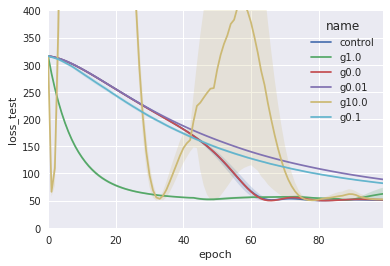

In [48]:
sns.tsplot(time="epoch", value="loss_test",
                 unit="experiment", condition="name",
                 data=df_tot, ci=[68]
          ,estimator=np.median)

plt.ylim(0,400)

plt.show()

In [ ]:
# exps['test1']['name'] = 'dde'

In [ ]:
df_window3['name'] = 'dde1'

In [ ]:
len(grads[4])

In [ ]:
all_grads = [layer for layer in [epoch for epoch in grads]

In [ ]:
np.linalg.norm(np.stack(all_grads),axis=2)

In [ ]:
choice = 'param'

if choice == 'grad':
    c = 0
else:
    c = 1

ps = []
gs = []
pgs = []
l = 3
fro = 300
to = 300

fro_rand = np.random.randint(fro)
to_rand = np.random.randint(to)

for e, pe in zip(grads,proc_grads):
    
    gs.append(e[l][0][fro_rand][to_rand])
    ps.append(e[l][1][fro_rand][to_rand])
    pgs.append(pe[l][0][fro_rand][to_rand])

gs = np.stack(gs)
ps = np.stack(ps)
pgs = np.stack(pgs)

print(gs.sum())
print(ps.sum())
print(pgs.sum())

plt.plot(range(len(gs)),gs)
plt.title('partial derivative - layer {} weight {},{}'.format(l,fro_rand,to_rand))
plt.xlabel('epoch')
plt.show()

plt.plot(range(len(ps)),ps)
plt.title('parameter - layer {} weight {},{}'.format(l,fro_rand,to_rand))
plt.xlabel('epoch')
plt.show()

plt.plot(range(len(pgs)),pgs)
plt.title('processed partial derivative - layer {} weight {},{}'.format(l,fro_rand,to_rand))
plt.xlabel('epoch')
plt.show()

In [ ]:

sums = []

for l in range(len(grads[10])):
    
    gs = []
    
    gs.append(np.sum(grads[2][l][0]))
    gs = np.stack(gs)
    sums.append(gs.sum())

sums

In [ ]:
gs[-1].shape

In [ ]:
grads[15]

In [ ]:
grads[10][300][0].shape

In [ ]:
len(grads[10])